###Summary 
* The top most reaction to food/drug is "Diarrhoea" - 25.2% and second one is "Vomiting"- 21.4%
* Out of 1000 event reports with a "Ovarian Cancer" reaction, the most outcome was "Medically Important" for reaction "Cosmetics" industry. Median age is 55 years.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
#import api_keys
import seaborn as sns

In [160]:
#Get another 1000 records for a date range as below
#Get FDA food event data between Jan 01, 2004 and Jan 1, 2004. 
#fda_food_url = "https://api.fda.gov/food/event.json?search=date_started:[20040101+TO+20160101]&limit=1000"
#food_event_data = requests.get(fda_food_url).json()

ov_cancer_url = "https://api.fda.gov/food/event.json?search=reactions:'ovarian+cancer'&limit=1000"
food_event_data = requests.get(ov_cancer_url).json()

In [163]:
#Empty list to append the food event report details
report_number_list =[]
outcomes_list = []
date_created_list = []
date_started_list = []
consumer_age_list = []
consumer_age_unit_list = []
consumer_gender_list = []

event_report_reaction =[]
event_report_product =[]
event_report_outcome =[]


#results key from the JSON data of the request contains the information about the food event.
if(('results' in food_event_data) and (bool(food_event_data['results']) == True)):
    for foodevent_record in food_event_data['results']:
            
        report_number_list.append(foodevent_record['report_number'])
        date_started_list.append(foodevent_record['date_started'])
        date_created_list.append(foodevent_record['date_created'])
        
        #If consumer details are available in the event report. 
        if(bool(foodevent_record['consumer']) == True):
            
            #Some reports, doesn't have consumer age data, hence checking if 'age' key exists
            if('age' in foodevent_record['consumer']):
                consumer_age_list.append(foodevent_record['consumer']['age'])
            else:
                consumer_age_list.append("")
            
            #Some reports, doesn't have consumer age unit data, hence checking if 'age_unit' key exists
            if('age_unit' in foodevent_record['consumer']):
                consumer_age_unit_list.append(foodevent_record['consumer']['age_unit'])
            else:
                consumer_age_unit_list.append("")
                
            #Some reports, doesn't have gender data, hence checking if 'gender' key exists
            if('gender' in foodevent_record['consumer']):
                consumer_gender_list.append(foodevent_record['consumer']['gender'])
            else:
                consumer_gender_list.append("")
        else:
            #If consumer details are not available append empty values
            consumer_age_list.append("")
            consumer_age_unit_list.append("")
            consumer_gender_list.append("")
          
        #Outcomes for the food event. There can be more than 1 outcome 
        for outcome in foodevent_record['outcomes']:
            event_report_outcome.append({'report_number':foodevent_record['report_number'],"outcome" : outcome})

        
        #reactions for the food event. There can be more than 1 reaction
        for reaction in foodevent_record['reactions']:
            event_report_reaction.append({'report_number':foodevent_record['report_number'],"reaction" : reaction.title()})
            
            
        #Product records for the event report. There can be more than 1 product/industry associated with it
        for product_record in foodevent_record['products']:
            event_report_product.append({"report_number":foodevent_record['report_number'],
                                         "role": product_record['role'].title(),
                                         "name_brand":product_record['name_brand'].title(),
                                         "industry_code":product_record['industry_code'],
                                         "industry_name":product_record['industry_name']})
            
            
#Create dictionary with column names and values for food event report 
food_event_report_dict = {"report_number":report_number_list,
                            "date_created":date_created_list,
                            "date_started":date_started_list,
                            "consumer_age":consumer_age_list,
                            "consumer_age_unit":consumer_age_unit_list,
                            "consumer_gender":consumer_gender_list
                        }

#Dataframe for food event report
food_event_report_df = pd.DataFrame(food_event_report_dict)
#Dataframe for food event report reactions. report_number is common
food_event_report_reactions_df = pd.DataFrame(event_report_reaction)
#Dataframe for food event report products. report_number is common
food_event_report_products_df = pd.DataFrame(event_report_product)
#Dataframe for food event report outcomes. report_number is common
food_event_report_outcomes_df = pd.DataFrame(event_report_outcome)


In [164]:
#Display first 5 records of dataframes
#display(food_event_report_df.head())   
display(food_event_report_reactions_df.head())
#display(food_event_report_outcomes_df.head())
display(food_event_report_products_df.head())


,report_number,reaction
0,202218,Ovarian Cancer
1,2018-CFS-003029,Ovarian Cancer
2,2019-CFS-008409,Ovarian Cancer
3,204715,Ovarian Cancer
4,214832,Ovarian Cancer


,report_number,role,name_brand,industry_code,industry_name
0,202218,Suspect,Exemption 4,53,Cosmetics
1,2018-CFS-003029,Suspect,Exemption 4,53,Cosmetics
2,2019-CFS-008409,Suspect,Exemption 4,53,Cosmetics
3,204715,Suspect,Exemption 4,53,Cosmetics
4,214832,Suspect,Exemption 4,53,Cosmetics


In [165]:
#Convert the string date_created and date_started to datetime format
food_event_report_df["date_created"] = pd.to_datetime(food_event_report_df["date_created"])
food_event_report_df["date_started"] = pd.to_datetime(food_event_report_df["date_started"])

#Get only the year part of created  date
food_event_report_df['year_created'] = food_event_report_df['date_created'].dt.year

#Query dataframe to get reports only for date range
ovcancer_reactions_df = food_event_report_df.query("year_created >= 2000")
ovcancer_reactions_df["consumer_age"]= pd.to_numeric(ovcancer_reactions_df["consumer_age"])

In [166]:
#Get the dataframe ready for plot - "Display of Events by Outcomes for Ovarian Cancer Reaction"
#merge with outcomes df with merged df from above step
inner_merge_reportno_df = pd.merge(ovcancer_reactions_df,food_event_report_outcomes_df, on="report_number")


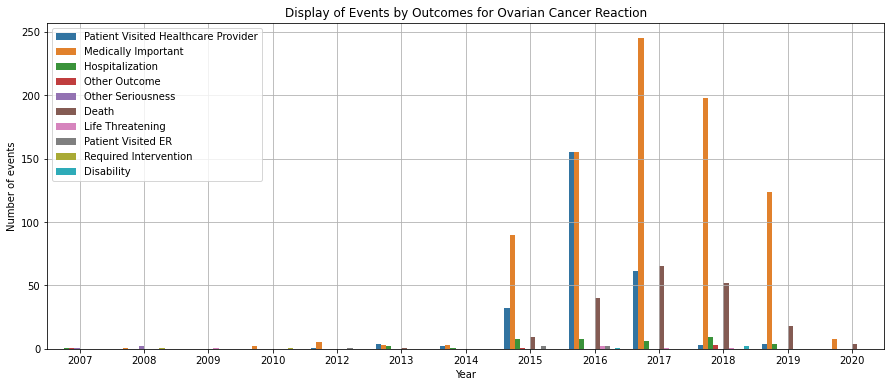

In [167]:
#plot - Display of Events by Outcomes for Ovarian Cancer Reaction
fig,ax = plt.subplots()
fig.set_size_inches([15,6])
ax = sns.countplot(x =inner_merge_reportno_df.year_created,data = inner_merge_reportno_df,
                   ax=ax,hue=inner_merge_reportno_df.outcome)
ax.set_title("Display of Events by Outcomes for Ovarian Cancer Reaction")
ax.set_ylabel("Number of events")
ax.set_xlabel("Year")
ax.legend(loc='upper left')
ax.grid(True)

In [174]:
#Ovarian cancer by age plot. What products caused this reaction?
# industry_name entries are blank in some reports. Replace it with text "Data unavailable"
food_event_report_products_df.loc[food_event_report_products_df.industry_name == "",'industry_name'] = "Data Unavailable"

#merge with outcomes df with merged df from above step
merged_reportno_df = pd.merge(ovcancer_reactions_df,food_event_report_products_df, on="report_number")

merged_reportno_df = merged_reportno_df[(merged_reportno_df["consumer_age_unit"]=="year(s)")]


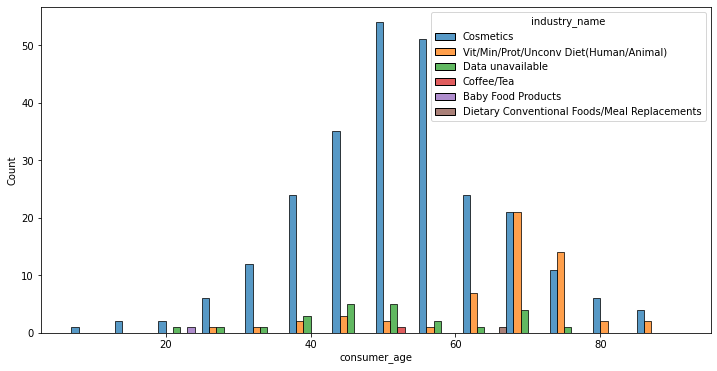

In [181]:
fig,ax = plt.subplots()
fig.set_size_inches([12,6])
ax= sns.histplot(x='consumer_age',data=merged_reportno_df,
                 hue='industry_name',multiple="dodge",ax=ax)

In [153]:
# Get the data for reactions count
reaction_count_url = "https://api.fda.gov/food/event.json?count=reactions.exact"
reaction_count_data = requests.get(reaction_count_url).json()


In [171]:
#import json

#f = open('reactions_count.json',)
#reaction_count_data =  json.load(f)

reaction_count_list = []
#results key from the JSON data of the request contains the information about the food event.
if(('results' in reaction_count_data) and (bool(reaction_count_data['results']) == True)):
    for cnt_record in reaction_count_data['results']:
        reaction_count_list.append({"reaction": cnt_record["term"].title(),"count":cnt_record["count"]})

#f.close()
        
reaction_count_df = pd.DataFrame(reaction_count_list)


In [172]:
#reaction_count_df['reaction'] = reaction_count_df['reaction'].str.title()
display(reaction_count_df.head())

,reaction,count
0,Diarrhoea,13933
1,Vomiting,11830
2,Ovarian Cancer,11719
3,Nausea,10012
4,Abdominal Pain,7845


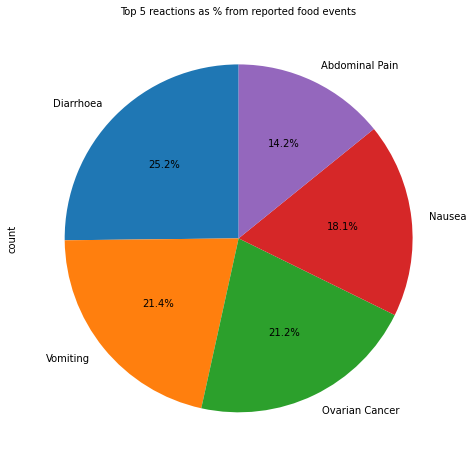

In [173]:
#plot pie chart to display top 5 reactions
fig,ax = plt.subplots()
fig.set_size_inches([8,8])

reaction_count_df.head().plot(kind='pie',y="count",ax=ax,
                        startangle=90,shadow=False,labels=reaction_count_df.reaction,
                        autopct='%1.1f%%',legend=False,fontsize=10)


ax.set_title("Top 5 reactions as % from reported food events",fontsize=10)
plt.show()


In [176]:


ovcancer_reactions_df["consumer_age"].unique()

#merged_reportno_df[(merged_reportno_df["consumer_age_unit"]!="") & (merged_reportno_df["consumer_age_unit"]=="year(s)")]
merged_reportno_df[(merged_reportno_df["consumer_age_unit"]=="year(s)")]
#merged_reportno_df[merged_reportno_df['consumer_age'] == 4]

,report_number,date_created,date_started,consumer_age,consumer_age_unit,consumer_gender,year_created,role,name_brand,industry_code,industry_name
2,2019-CFS-008409,2019-08-16,2010-07-01,52.0,year(s),F,2019,Suspect,Exemption 4,53,Cosmetics
5,2019-CFS-003008,2019-03-22,2010-12-01,61.0,year(s),F,2019,Suspect,Exemption 4,53,Cosmetics
6,2019-CFS-010156,2019-10-03,2016-12-01,72.0,year(s),F,2019,Suspect,Exemption 4,53,Cosmetics
11,2017-CFS-003079,2017-12-28,2014-10-21,42.0,year(s),F,2017,Suspect,Exemption 4,53,Cosmetics
12,191837,2015-12-04,2015-04-16,70.0,year(s),M,2015,Suspect,Calcium 600Mg W Vit D 800Iu 9T 1Ab (Vitamin D ...,54,Vit/Min/Prot/Unconv Diet(Human/Animal)
...,...,...,...,...,...,...,...,...,...,...,...
1056,2019-CFS-008051,2019-08-08,2004-03-29,38.0,year(s),F,2019,Suspect,Exemption 4,53,Cosmetics
1057,202318,2016-10-04,2014-07-01,53.0,year(s),F,2016,Suspect,Exemption 4,53,Cosmetics
1058,217194,2017-08-31,2008-04-01,49.0,year(s),F,2017,Suspect,Exemption 4,53,Cosmetics
1061,2018-CFS-010079,2018-08-07,2018-01-01,60.0,year(s),F,2018,Suspect,Exemption 4,53,Cosmetics


In [180]:
print(merged_reportno_df["consumer_age"].mean())
print(merged_reportno_df["consumer_age"].median())
print(merged_reportno_df["consumer_age"].mode())
#Calculate mean and median of consumer_age for 'Cosmetics' industry
print(merged_reportno_df[merged_reportno_df['industry_name'] == 'Cosmetics']["consumer_age"].agg(["mean","median"]))


55.788690476190474
55.0
0    72.0
dtype: float64
mean      53.754941
median    53.000000
Name: consumer_age, dtype: float64


In [ ]:
array(['', 'year(s)', 'Decade(s)','month(s)','day(s)'], dtype=object)


In [ ]:
#plot - Display of Events by Outcomes for Ovarian Cancer Reaction
fig,ax = plt.subplots()
fig.set_size_inches([15,6])
ax = sns.countplot(x =merged_reportno_df.year_created,data = merged_reportno_df,
                   ax=ax,hue=merged_reportno_df.industry_name)
ax.set_title("Industry names for Ovarian Cancer Reaction")
ax.set_ylabel("Number of events")
ax.set_xlabel("Year")
ax.legend(loc='upper left')
ax.grid(True)